# Doing Data Science: chapter 2 - Housing Dataset

Python code for the exercise on the RealDirect study about the housing dataset ("*improve the way people sell and buy houses*").

**Author**: Damien Garaud

**Project on Github**: https://github.com/garaud/doing_pydata_science

## Getting Data 

Clone the official Github project at https://github.com/oreillymedia/doing_data_science and unzip the `dds_datasets.zip` file. You'll find a new ZIP file named `dds_chapter2_rollingsales.zip`. Then, you'll get five XLS files:

- `rollingsales_bronx.xls`
- `rollingsales_brooklyn.xls`
- `rollingsales_manhattan.xls`
- `rollingsales_queens.xls`
- `rollingsales_statenisland.xls`

**Note**: for each carried out task, I'll try to write a **function**. Functions are good.

## Modules

In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

# useful to explore data with null values
import missingno as msno

In [4]:
print(pd.__version__)

2.2.3


In [5]:
sns.set_context('talk')

**Note**: about the missingno package, visit https://github.com/ResidentMario/missingno You can install it with conda.

## Reading Data

You continue to use pandas for XLS files reading. Suppose you have the `rollingsales_AREA.xls` files in the `data` directory.

The relevant row number to extract header is the row no.5 (note: row spreadsheet begins to 1).

In [6]:
def read_data(fname):
    """Read data from an Excel file
    """
    return pd.read_excel(fname, header=4)

In [8]:
brooklyn = read_data("data/dds_datasets/dds_ch2_rollingsales/rollingsales_manhattan.xls")

In [9]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27395 entries, 0 to 27394
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         27395 non-null  int64         
 1   NEIGHBORHOOD                    27395 non-null  object        
 2   BUILDING CLASS CATEGORY         27395 non-null  object        
 3   TAX CLASS AT PRESENT            27395 non-null  object        
 4   BLOCK                           27395 non-null  int64         
 5   LOT                             27395 non-null  int64         
 6   EASE-MENT                       27395 non-null  object        
 7   BUILDING CLASS AT PRESENT       27395 non-null  object        
 8   ADDRESS                         27395 non-null  object        
 9   APART
MENT
NUMBER               27395 non-null  object        
 10  ZIP CODE                        27395 non-null  int64         
 11  RE

21 columns and several different data

## Load and Clean up

Quoting: *First challenge: load in and clean up the data. Next, conduct
exploratory data analysis in order to find out where there are
outliers or missing values, decide how you will treat them, make
sure the dates are formatted correctly, make sure values you
think are numerical are being treated as such, etc.*

Rename some column names (there are some `\n`)

In [12]:
def clean_columns(df):
    """Clean some columns name
    """
    df.columns = [x.replace('\n', ' ').lower() for x in df.columns]
    return df.rename({'apart ment number': 'apartment number',
                           'ease-ment': 'easement'}, axis=1)
    
def missing_string(df, colnames):
    """Strip content and fill empty string with NaN
    """
    df = df.copy()
    for col in colnames:
        df[col] = df[col].str.strip().apply(lambda x: None if not x else x)
    return df

Column `apart ment number` sounds strange and this is an object (i.e. a string). Rename it!

In [13]:
brooklyn = clean_columns(brooklyn)

In [14]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27395 entries, 0 to 27394
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         27395 non-null  int64         
 1   neighborhood                    27395 non-null  object        
 2   building class category         27395 non-null  object        
 3   tax class at present            27395 non-null  object        
 4   block                           27395 non-null  int64         
 5   lot                             27395 non-null  int64         
 6   easement                        27395 non-null  object        
 7   building class at present       27395 non-null  object        
 8   address                         27395 non-null  object        
 9   apartment number                27395 non-null  object        
 10  zip code                        27395 non-null  int64         
 11  re

OK, sometimes, you can have two digits or one digits and letters. We can normalize that, i.e. discard some trailing whitespaces. And replace every empty string by None.

In [15]:
brooklyn = missing_string(brooklyn, ['apartment number'])

Let's see if you have other string field with the same issues

In [16]:
brooklyn['apartment number'].sample(10)

20158    B0901
12304      NaN
5266      None
18236      NaN
25885     None
11615      NaN
14631     None
3468       49B
4259      None
16628     None
Name: apartment number, dtype: object

### Type of Columns

Are integer and string columns qualitative or sequential data?

* Districts or zipcodes could be qualitative data
* Years or prices could be sequential data (i.e. you can sort them)

In [17]:
def number_unique_values(data):
    """Count the number of unique values for each column
    
    Return a DataFrame with the name of the columns, the type and the number of unique values
    """
    res = pd.DataFrame([(name, data[name].dtype.name, data[name].nunique()) for name in data],
                      columns=['name', 'type', 'number'])
    return res.sort_values(by=['type', 'number'])

In [18]:
nuniq = number_unique_values(brooklyn)

In [19]:
nuniq

,name,type,number
20,sale date,datetime64[ns],353
0,borough,int64,1
17,tax class at time of sale,int64,3
10,zip code,int64,48
12,commercial units,int64,52
11,residential units,int64,121
13,total units,int64,132
16,year built,int64,135
14,land square feet,int64,1284
4,block,int64,1421


**Note** that *most of the time*, `object` type means `string`.

When you have a small number of unique values in comparison with the number of rows, it could be qualitative data.

For a predictive model, the columns with a unique value are irrelevant.
I'm specifying two list of columns:
- columns with string data
- columns with integer data

In [20]:
intcols = nuniq.query("type == 'int64'")['name'].values.tolist()
strcols = nuniq.query("type == 'object'")['name'].values.tolist()

### Crazy Values

Data are always messed up. Check if some integer/float columns contain some crazy values, e.g. -999 for a positive float or 0 for years...

In [21]:
def range_columns(data):
    """Min/max values for each integer columns
    """
    intcols = data.dtypes[data.dtypes == 'int64'].index.tolist()
    res = data[intcols].describe().T
    return res[["min", "50%", "max"]]

In [22]:
range_columns(brooklyn)

,min,50%,max
borough,1.0,1.0,1.000000e+00
block,7.0,1047.0,2.250000e+03
lot,1.0,1007.0,9.117000e+03
zip code,0.0,10019.0,1.046300e+04
residential units,0.0,0.0,1.328000e+03
commercial units,0.0,0.0,6.040000e+02
total units,0.0,1.0,1.349000e+03
land square feet,0.0,0.0,2.136500e+05
gross square feet,0.0,0.0,1.970736e+06
year built,0.0,1928.0,2.013000e+03


zip code, sale price, square feet or year equal to `0` is quite strange! Next step: **identify** null values. For some integer values, you can suppose that 0 is a null value. For string values, you can suppose that the empty string is null. You have a dedicated function for the second issue.

In [23]:
brooklyn = missing_string(brooklyn, strcols)

Let's select the integer columns where you can say: "zero value is a null value".

In [24]:
intcols

['borough',
 'tax class at time of sale',
 'zip code',
 'commercial units',
 'residential units',
 'total units',
 'year built',
 'land square feet',
 'block',
 'lot',
 'gross square feet',
 'sale price']

In [25]:
intcols_to_nullify = ['zip code', 'year built', 'land square feet',
                      'gross square feet', 'sale price']

In [26]:
brooklyn[intcols_to_nullify].head()

,zip code,year built,land square feet,gross square feet,sale price
0,10014,0,0,0,2214693
1,10014,0,0,0,1654656
2,10014,0,0,0,1069162
3,10014,0,0,0,1374637
4,10014,0,0,0,1649565


In [27]:
brooklyn[intcols_to_nullify] = brooklyn[intcols_to_nullify].replace(0, np.nan)

Now, you have a number of non-null object values which is quite different of the total number of rows.

Now, you have a better representation of your data. As you can see, you have multiple rows where there are some null values.

In [28]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27395 entries, 0 to 27394
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         27395 non-null  int64         
 1   neighborhood                    27378 non-null  object        
 2   building class category         23941 non-null  object        
 3   tax class at present            1433 non-null   object        
 4   block                           27395 non-null  int64         
 5   lot                             27395 non-null  int64         
 6   easement                        0 non-null      object        
 7   building class at present       27252 non-null  object        
 8   address                         27395 non-null  object        
 9   apartment number                9195 non-null   object        
 10  zip code                        27394 non-null  float64       
 11  re

You can use the `missingno` package which works well with pandas and seaborn to visualize features (i.e. columns) with missing values.

<Axes: >

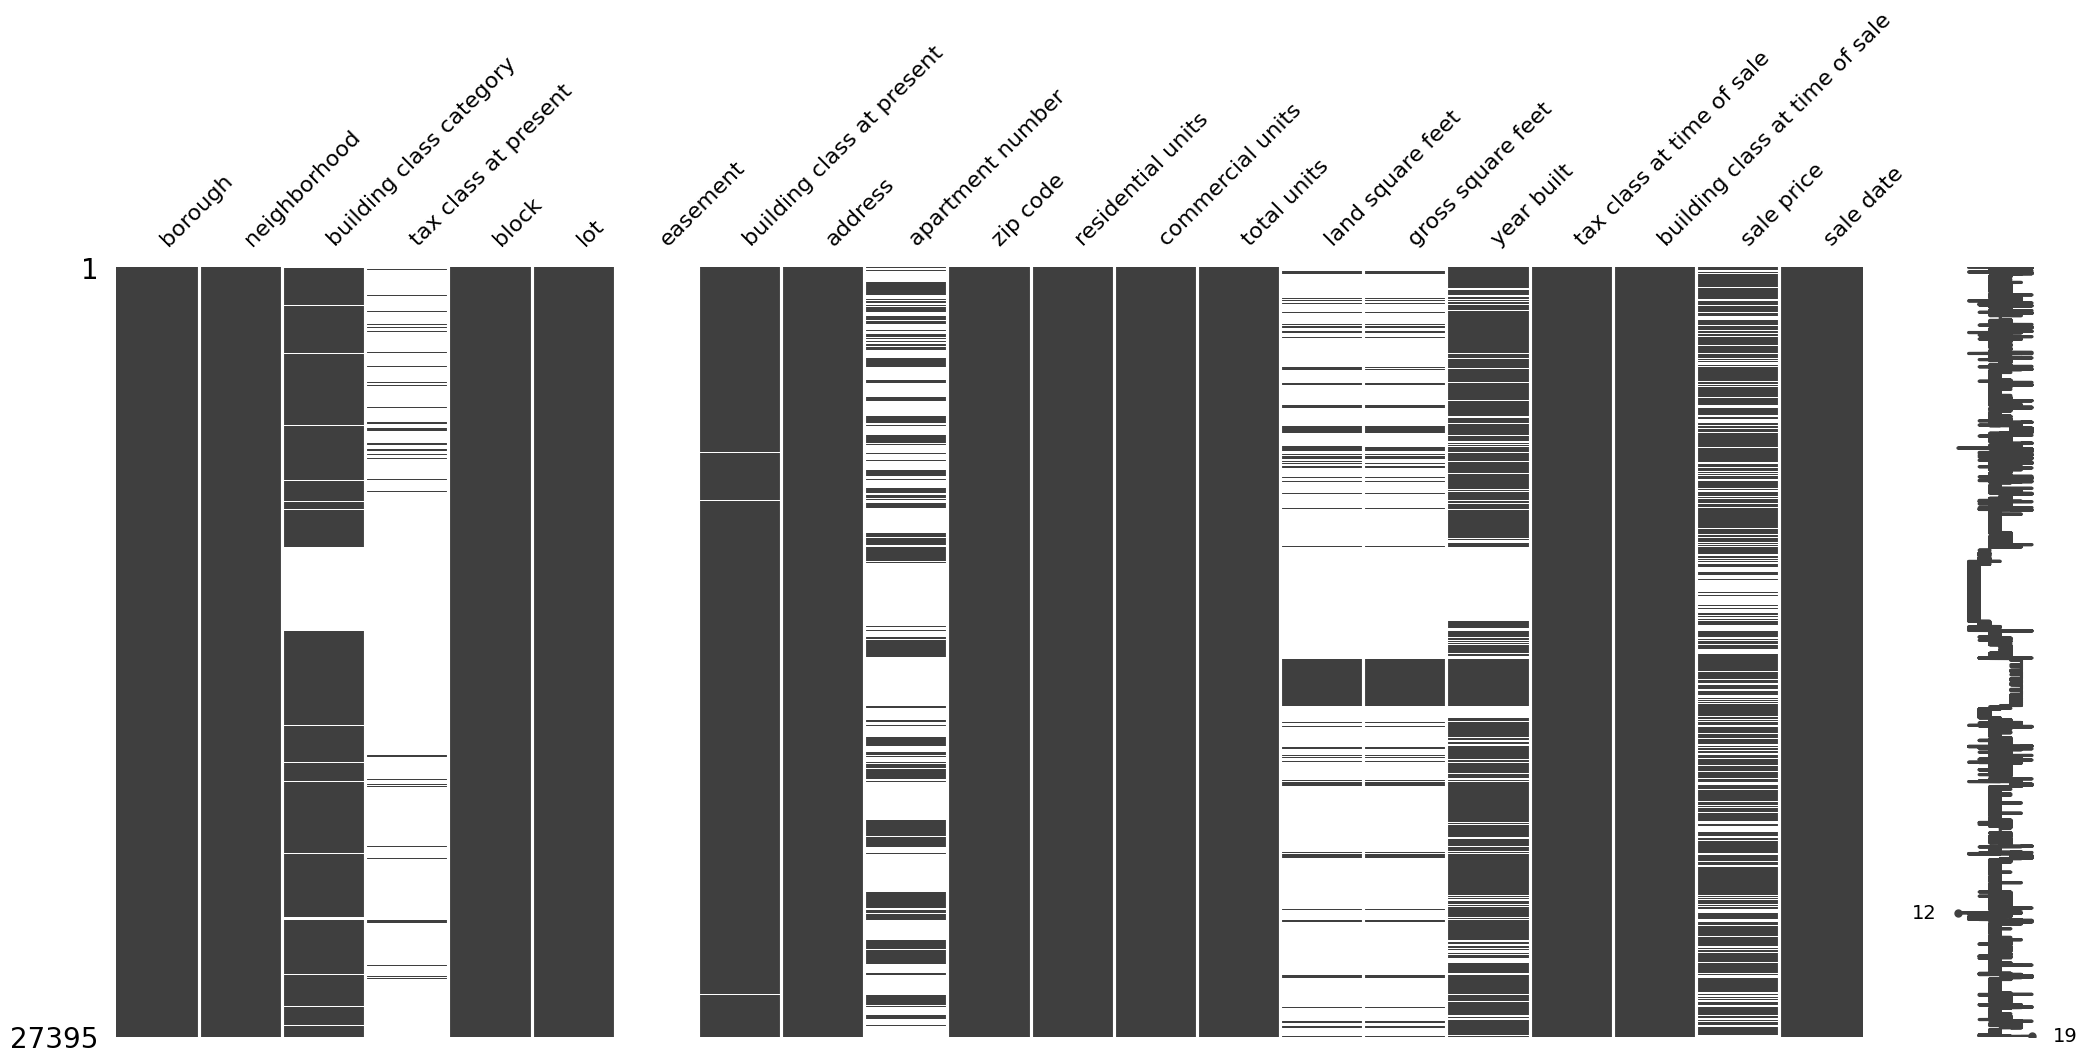

In [29]:
msno.matrix(brooklyn)

You can also plot the correlation of "number of missing values" between each feature.

<Axes: >

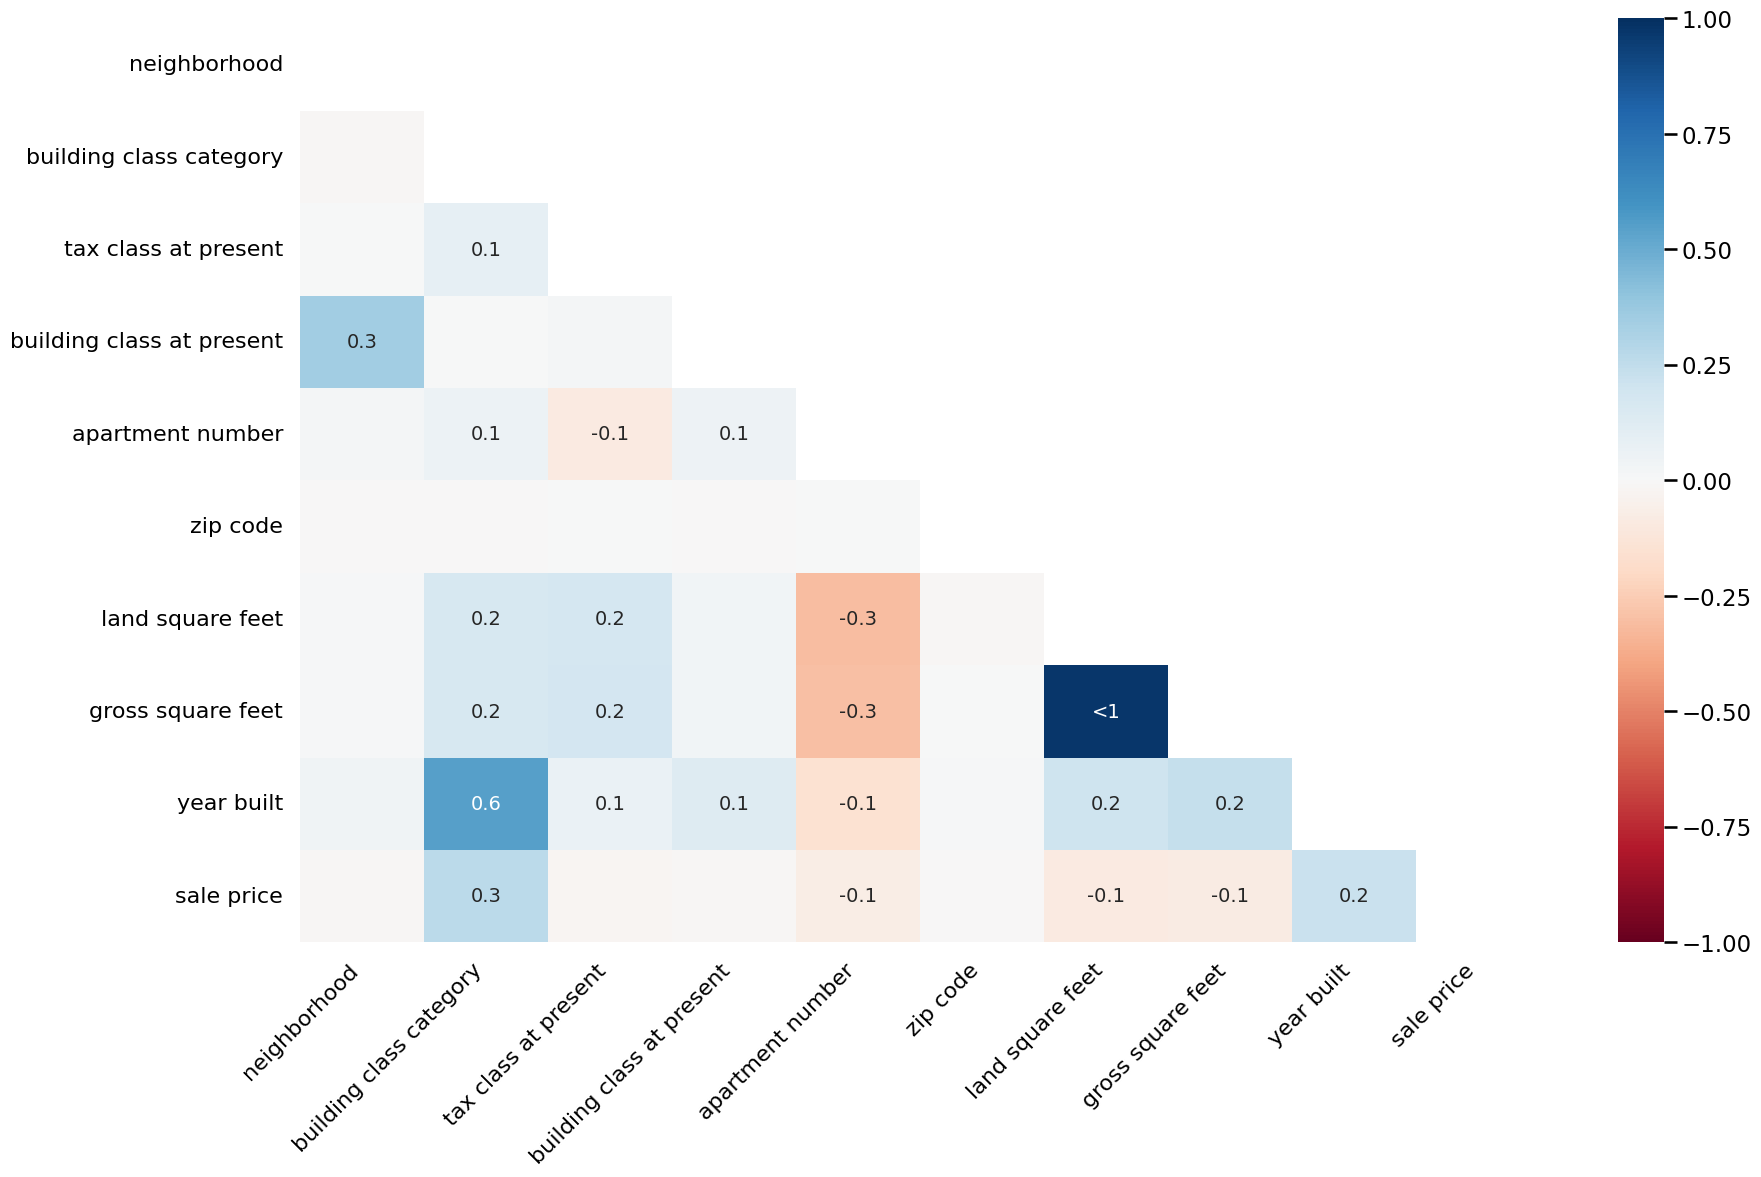

In [30]:
msno.heatmap(brooklyn)

As you can see, there is a huge correlation between the 'land square feet' and 'gross square feet' feature. It's not very suprising since when you don't have the value of the first feature, you don't have the second one.

For a predictive model which tries to estimate the sale price for instance, you need to remove some lines (where you have these null values) and some features (unique values, etc.). In this study, you can drop `easement` and `borough` columns.

In [31]:
intcols.remove('borough')
brooklyn = brooklyn.drop(['easement', 'borough'], axis=1)

### Correlation

<Axes: >

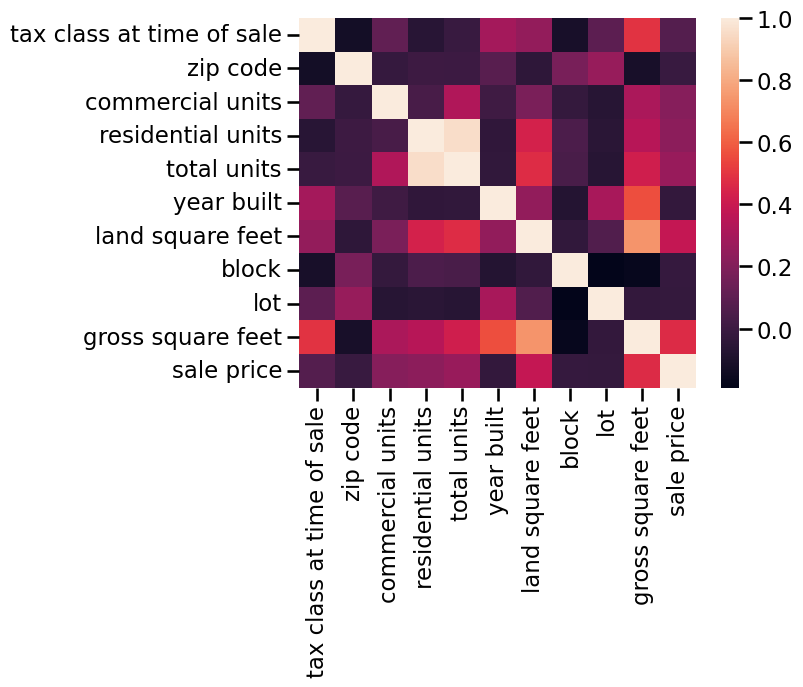

In [32]:
sns.heatmap(brooklyn[intcols].corr())

In [34]:
brooklyn["price per sqft"] = brooklyn["sale price"] / brooklyn["gross square feet"]

In [35]:
brooklyn["price per sqft"].describe()

count     2765.000000
mean       466.896610
std       1243.590892
min          0.000005
25%          0.513070
50%        104.546363
75%        573.140550
max      34777.046784
Name: price per sqft, dtype: float64

In [44]:
# calculate IQR for column Height
Q1 = brooklyn["price per sqft"].quantile(0.1)
Q3 = brooklyn["price per sqft"].quantile(0.9)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = brooklyn[(brooklyn["price per sqft"] < Q1 - threshold * IQR) | (brooklyn["price per sqft"] > Q3 + threshold * IQR)]

In [45]:
outliers # 227


,neighborhood,building class category,tax class at present,block,lot,building class at present,address,apartment number,zip code,residential units,commercial units,total units,land square feet,gross square feet,year built,tax class at time of sale,building class at time of sale,sale price,sale date,price per sqft
158,ALPHABET CITY,29 COMMERCIAL GARAGES,NaN,384,33,G4,11 AVENUE C,None,10009.0,0,1,1,5893.0,1419.0,1961.0,4,G4,7000000.0,2012-09-06,4933.051445
190,CHELSEA,01 ONE FAMILY HOMES,NaN,770,21,A9,233 WEST 20TH,None,10011.0,1,0,1,1064.0,1260.0,1901.0,1,A9,7935000.0,2013-06-27,6297.619048
1117,CHELSEA,22 STORE BUILDINGS,NaN,700,48,K1,524 WEST 29TH STREET,None,10001.0,0,1,1,2469.0,2469.0,1930.0,4,K1,24688000.0,2012-11-14,9999.189955
1123,CHELSEA,22 STORE BUILDINGS,NaN,738,79,K9,58 9 AVENUE,None,10011.0,2,1,3,1692.0,3842.0,1920.0,4,K9,18200000.0,2013-04-08,4737.116085
1171,CHELSEA,29 COMMERCIAL GARAGES,NaN,696,32,G5,239 10TH AVENUE,None,10001.0,0,1,1,5520.0,1904.0,1950.0,4,G5,23500000.0,2013-07-31,12342.436975
1290,CHINATOWN,21 OFFICE BUILDINGS,NaN,201,13,O9,178 CANAL STREET,None,10013.0,0,1,1,3540.0,12173.0,1958.0,4,O9,40750000.0,2012-12-03,3347.572497
2155,EAST VILLAGE,07 RENTALS - WALKUP APARTMENTS,2B,451,44,C7,335 EAST 9TH STREET,None,10003.0,8,2,10,2306.0,6510.0,1900.0,2,C7,20250000.0,2013-03-14,3110.599078
2545,FASHION,29 COMMERCIAL GARAGES,NaN,759,26,G2,325 WEST 35TH STREET,None,10001.0,0,1,1,1760.0,1760.0,1940.0,4,G2,13400000.0,2012-12-18,7613.636364
3631,GRAMERCY,07 RENTALS - WALKUP APARTMENTS,2A,872,74,C5,104 EAST 17TH STREET,None,10003.0,6,0,6,2156.0,4257.0,1900.0,2,C5,23581250.0,2012-12-19,5539.405685
3647,GRAMERCY,07 RENTALS - WALKUP APARTMENTS,NaN,905,42,C7,230 EAST 25TH STREET,None,10010.0,35,3,38,3950.0,17364.0,1905.0,2,C7,380000000.0,2013-01-01,21884.358443


In [46]:
df = brooklyn.drop(outliers.index)

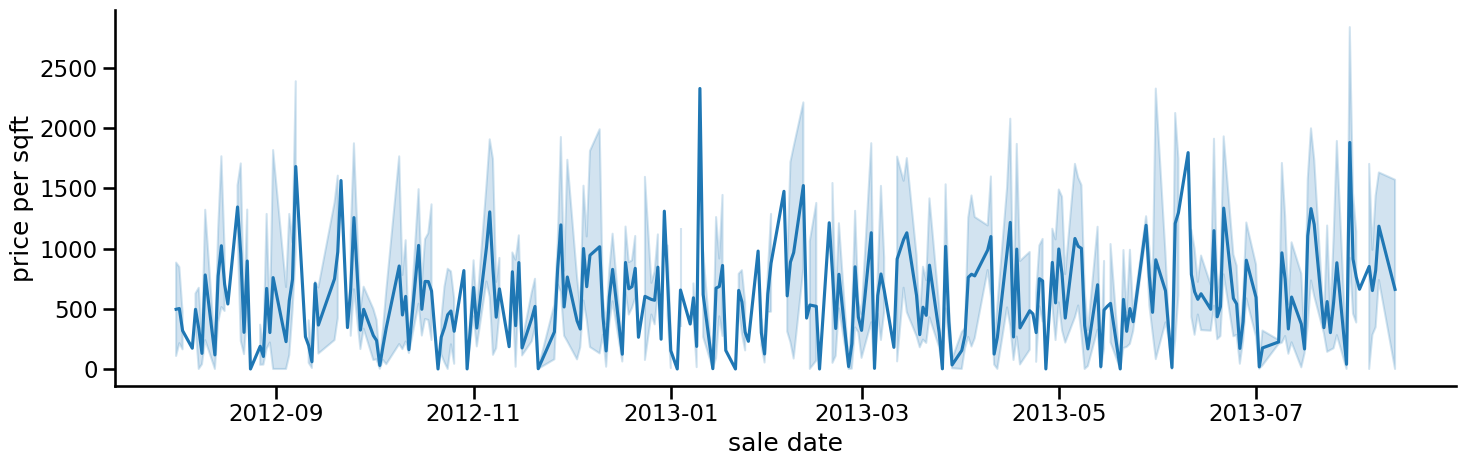

In [50]:

sns.relplot(data=df, x="sale date", y="price per sqft", kind="line", aspect =3)
